In [1]:
%load_ext autoreload
%autoreload 2

## Loading stuff

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from lda import LDA


In [3]:
np.random.seed(0)
# load data
data = sio.loadmat('kos_doc_data.mat')
A = np.array(data['A'])   # word counts for training (doc ID, word ID, count)
B = data['B']             # word counts for testing  (doc ID, word ID, count)
V = data['V']             # set of words = vocabulary

# defining indexes
DOCID_IND = 0
WORDID_IND = 1
COUNT_IND = 2

# CONVERTING MATLAB INDECES IN STANDARD PROGRAMMING INDICES
A[:,WORDID_IND] -= 1
B[:,WORDID_IND] -= 1

A.shape, B.shape, V.shape

((205211, 3), (147949, 3), (6906, 1))

## Question A

#### Using A, find the maximum likelihood multinomial over words, and show the 20 largest probability items in a histogram

In [4]:
total_words = np.sum(A[:,COUNT_IND])
betas = np.array([np.sum(A[A[:,WORDID_IND] == i][:,COUNT_IND])/total_words for i in range(len(V))])

print(betas[:4])


[1.47113991e-05 6.25234463e-05 4.78120472e-05 2.94227983e-05]


(-0.7, 20.7)

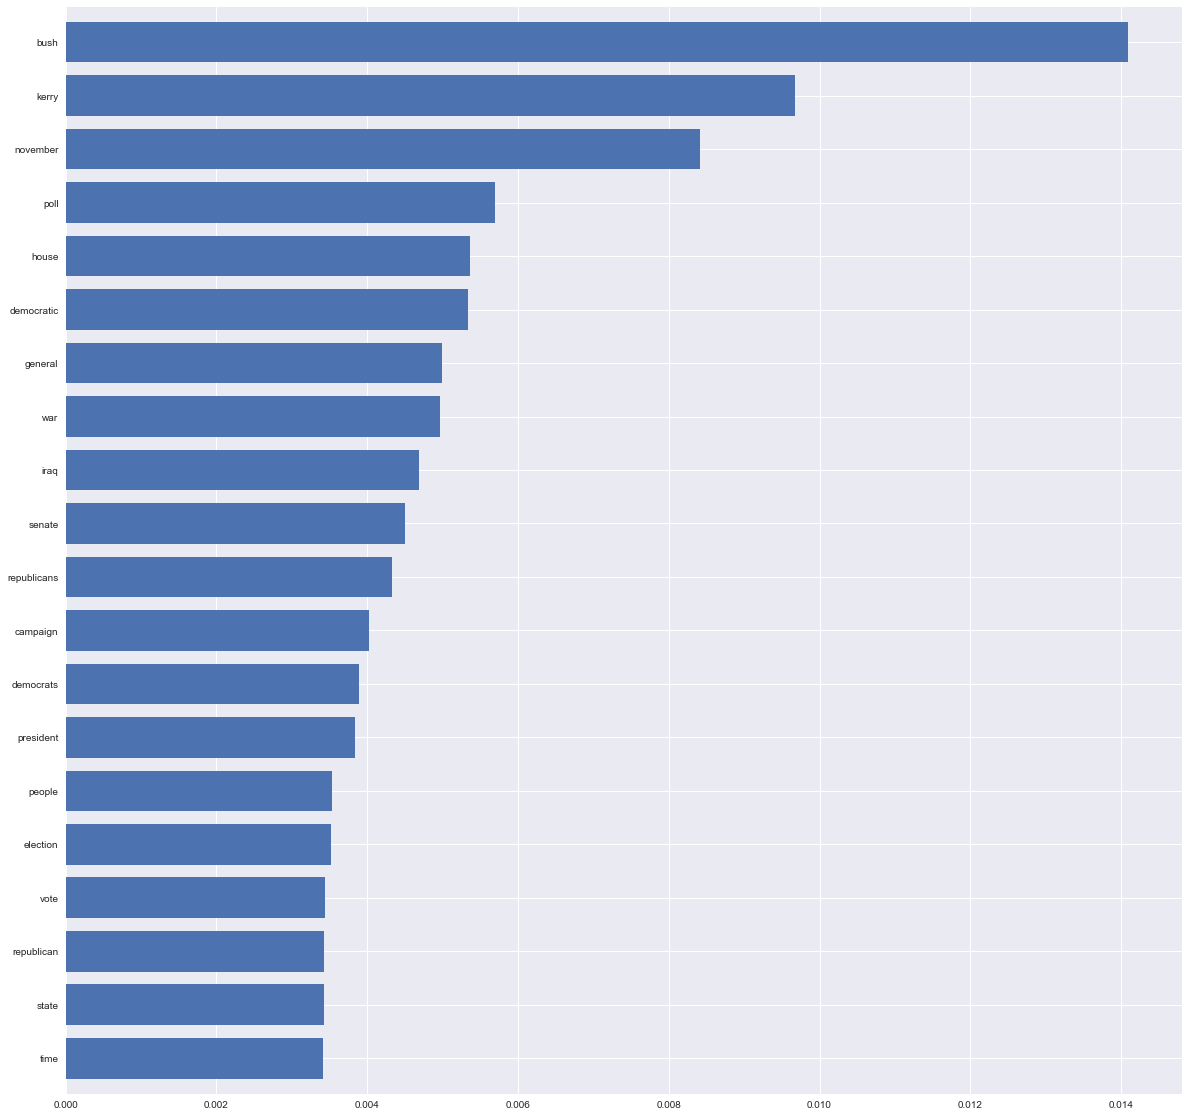

In [5]:
plt.style.use('seaborn')

N_HIGHEST_WORDS = 20

M = len(betas)
xx = np.linspace(0, N_HIGHEST_WORDS, N_HIGHEST_WORDS)
plt.figure(figsize=(N_HIGHEST_WORDS, N_HIGHEST_WORDS))

sorted_indices = np.argsort(betas)[::-1]
sorted_names = V[sorted_indices]

printed_betas = betas[sorted_indices][:N_HIGHEST_WORDS]
printed_names = sorted_names[:N_HIGHEST_WORDS][::-1]
printed_names = [name[0][0] for name in printed_names]

plt.barh(xx, printed_betas[::-1])
plt.yticks(xx, labels=printed_names)
plt.ylim([-0.7, N_HIGHEST_WORDS+0.7])

## Testing

In [ ]:
K = 20  # number of clusters
alpha = .1  # parameter of the Dirichlet over mixture components
gamma = .1  # parameter of the Dirichlet over words

perplexity, swk = LDA(A, B, K, alpha, gamma)
print(perplexity)

I = 20
indices = np.argsort(-swk, axis=0)
indices = indices[:20, :]
top_words = V[indices]
for topic in top_words[:, :, 0].T:
    print('\n')
    for word in topic:
        print(word[0])